In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import datetime as dt
import seaborn as sns

In [398]:
transactions = pd.read_csv("Data/transactions.csv")
transactions.shape

(83488, 3)

In [374]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['new_years_day'] = np.where((transactions['date'].dt.month == 1) & (transactions['date'].dt.day == 1), 1,0)
transactions['day_cat'] = transactions['date'].dt.day_name()
transactions["trans_lag"] = transactions.groupby('store_nbr')['transactions'].shift(1)
transactions["trans_lag_2"] = transactions.groupby('store_nbr')['transactions'].shift(2)
transactions = transactions.dropna(subset=['trans_lag'])
transactions = transactions.dropna(subset=['trans_lag_2'])

In [375]:
transactions["store_nbr"] = transactions["store_nbr"].astype("category")

In [376]:
stores = pd.read_csv("Data/stores.csv")
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [396]:
df = pd.merge(transactions, stores, on = 'store_nbr')
df['day_nbr'] = df['day_cat'] +'_'+ df['store_nbr'].astype(str)
df['store_nbr'] = df['store_nbr'].astype(str)
df['cluster'] = df['cluster'].astype('category')
df.head()

date store_nbr  transactions  new_years_day   day_cat  trans_lag  \
0 2013-01-03        25           887              0  Thursday     1038.0   
1 2013-01-04         1          1863              0    Friday     1833.0   
2 2013-01-04         2          2066              0    Friday     2033.0   
3 2013-01-04         3          3188              0    Friday     3026.0   
4 2013-01-04         4          1596              0    Friday     1551.0   

   trans_lag_2     city        state type cluster      day_nbr  
0        770.0  Salinas  Santa Elena    D       1  Thursday_25  
1       2111.0    Quito    Pichincha    D      13     Friday_1  
2       2358.0    Quito    Pichincha    D      13     Friday_2  
3       3487.0    Quito    Pichincha    D       8     Friday_3  
4       1922.0    Quito    Pichincha    D       9     Friday_4

In [408]:
X = df[["day_cat", "store_nbr", "day_nbr","trans_lag", 'city', 'state', 'type', 'cluster']]
X = pd.get_dummies(X, drop_first=True)
y = transactions.loc[:,"transactions"]

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=6, test_size = 10000)

# Iterate over the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# display(X_train.head())
display(X_train.shape)
display(X_test.shape)
# Train the model
model = LinearRegression()
# (X[1:], y[1:]) 
model.fit(X_train, y_train)
# Access the coefficients
coefficients = model.coef_
intercept = model.intercept_

# X_test = data_pipline(test,["family", "city"])
y_pred = pd.Series(model.predict(X_test))
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

(73380, 493)

(10000, 493)

Mean Squared Error: 79338.77659273462


In [409]:
resid = df.iloc[test_index]
y_pred = y_pred.to_frame(name='y_pred').reset_index(drop = True).set_index(resid.index)
resid = pd.merge(resid, y_pred, left_index=True, right_index=True, how='outer')
resid['residuals'] = resid['transactions'] - resid['y_pred']
resid.head()

date store_nbr  transactions  new_years_day day_cat  trans_lag  \
73380 2017-02-10        28          1127              0  Friday     1112.0   
73381 2017-02-10        29           986              0  Friday     1071.0   
73382 2017-02-10        30           703              0  Friday      736.0   
73383 2017-02-10        31          1277              0  Friday     1216.0   
73384 2017-02-10        32           532              0  Friday      551.0   

       trans_lag_2       city     state type cluster    day_nbr       y_pred  \
73380        906.0  Guayaquil    Guayas    E      10  Friday_28   985.612244   
73381        962.0  Guayaquil    Guayas    E      10  Friday_29  1234.335008   
73382        728.0  Guayaquil    Guayas    C       3  Friday_30   797.167370   
73383       1222.0   Babahoyo  Los Rios    B      10  Friday_31  1111.688072   
73384        571.0  Guayaquil    Guayas    C       3  Friday_32   599.473665   

        residuals  
73380  141.387756  
73381 -248.335008  
73382  -94.167370  
73383  165.311928  
73384  -67.473665

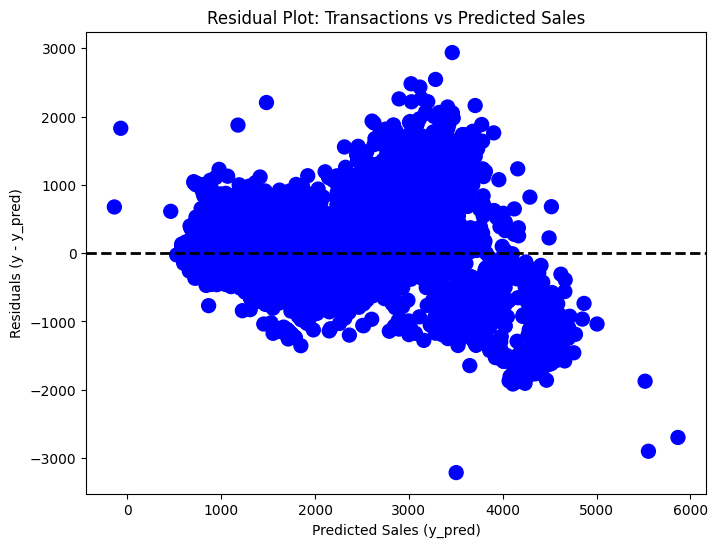

In [410]:
# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot with two colors based on 'new_years_day' (True or False)
plt.scatter(resid['y_pred'], resid['residuals'], 
            c=resid['new_years_day'].map({1: 'green', 0: 'blue'}), s=100)

# Add a horizontal line at 0 (for residuals)
plt.axhline(0, color='black', lw=2, linestyle='--')

# Add labels and title
plt.title('Residual Plot: Transactions vs Predicted Sales')
plt.xlabel('Predicted Sales (y_pred)')
plt.ylabel('Residuals (y - y_pred)')

# Show the plot
plt.show()

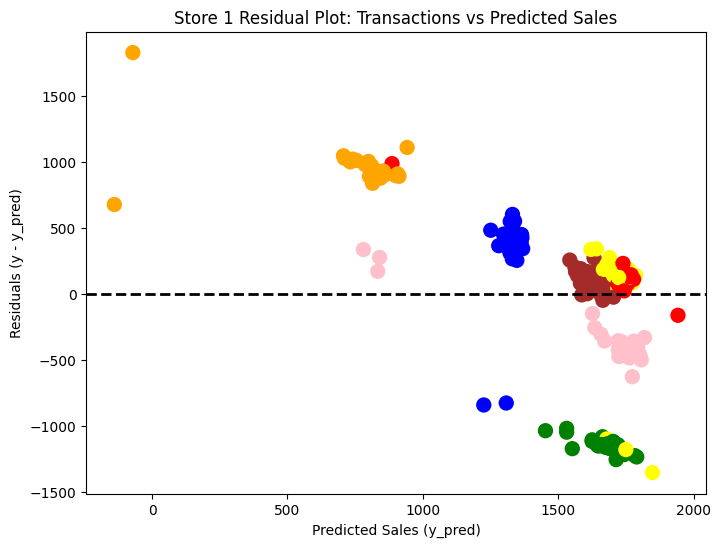

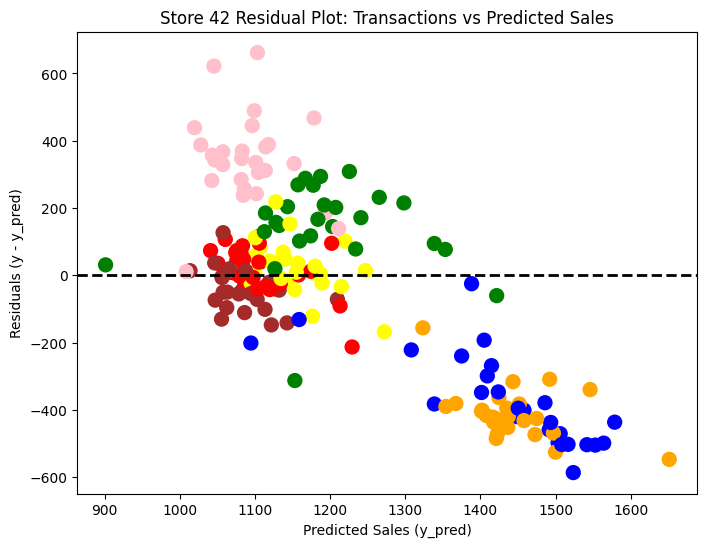

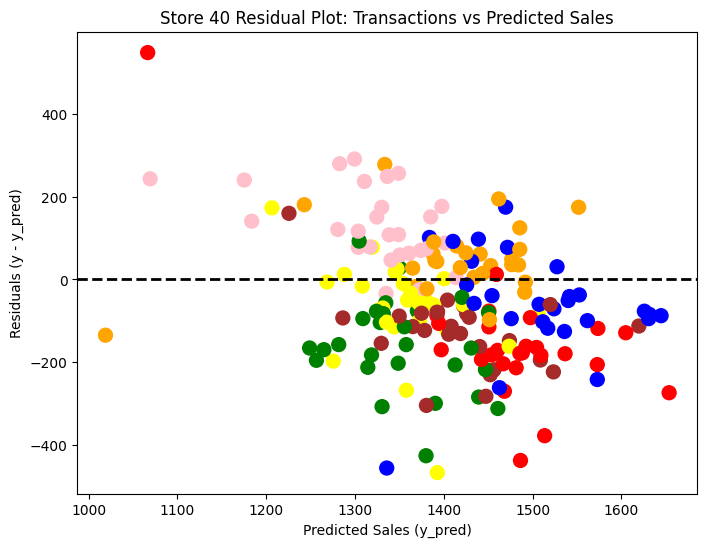

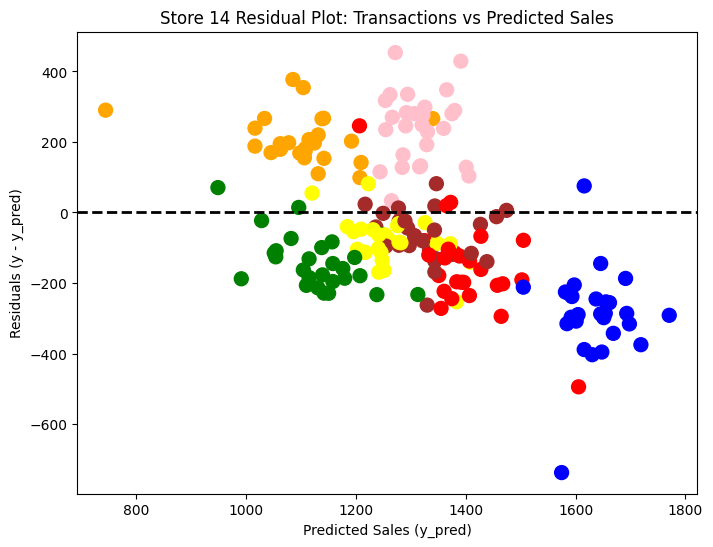

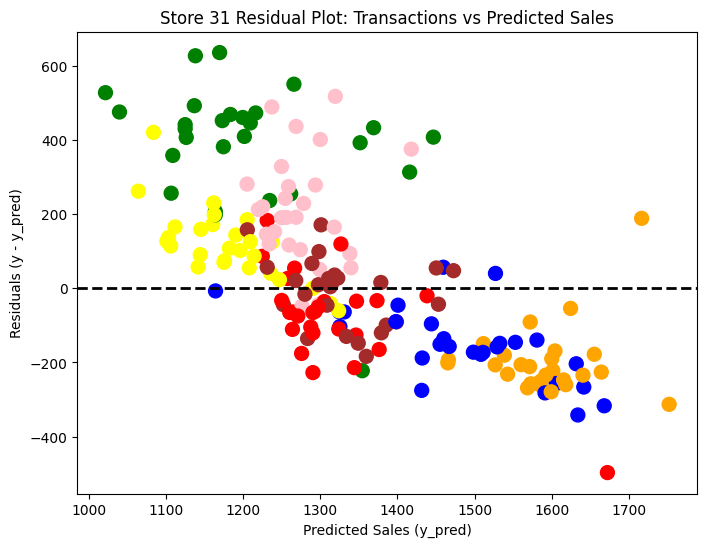

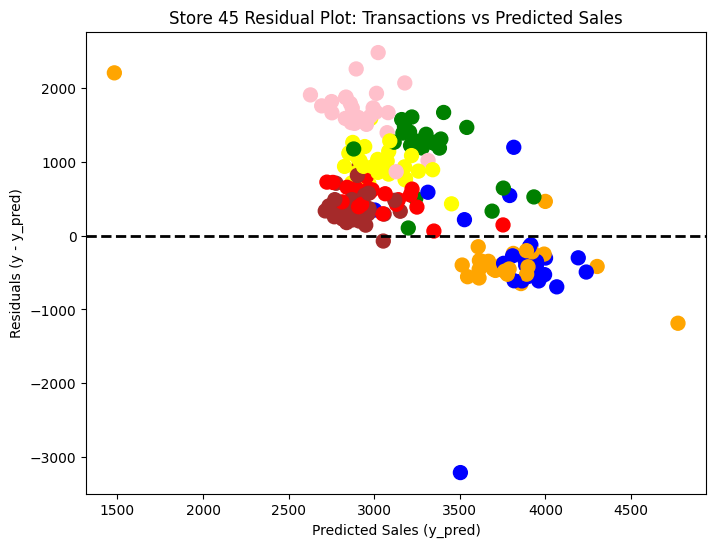

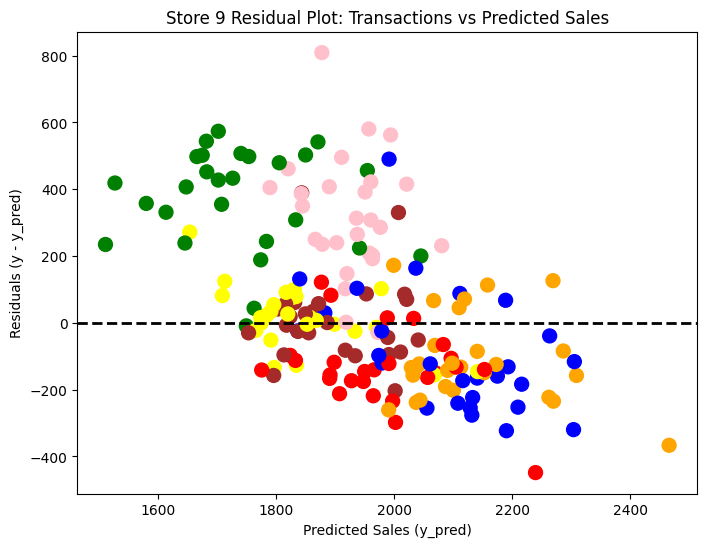

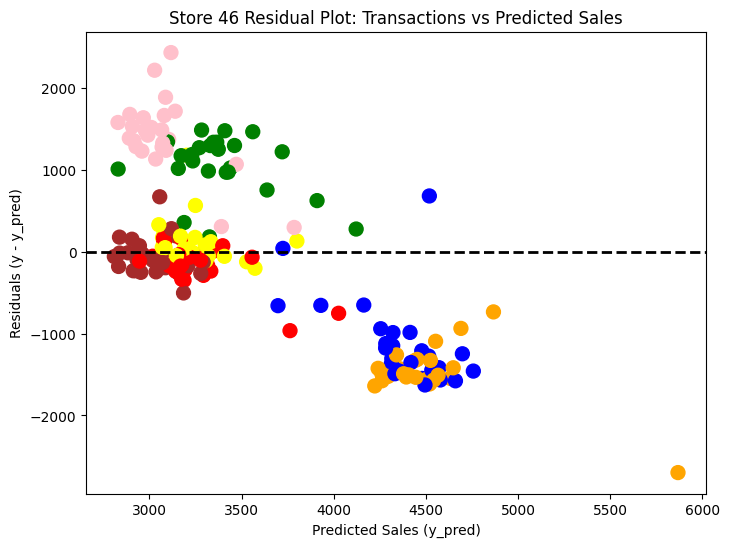

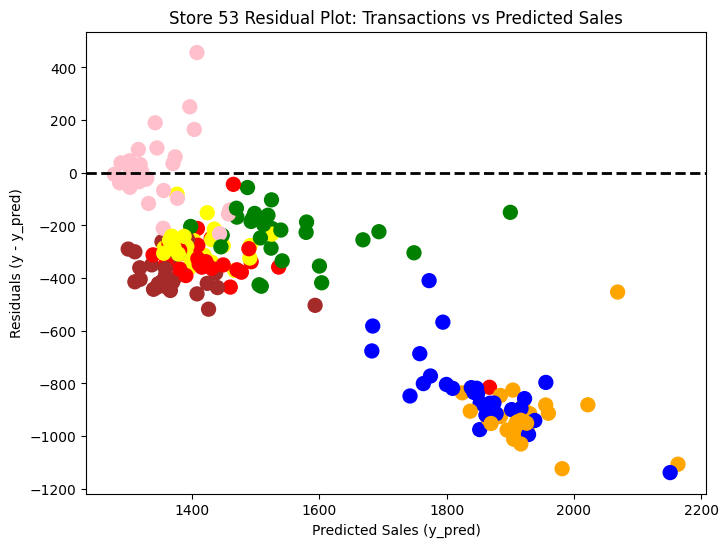

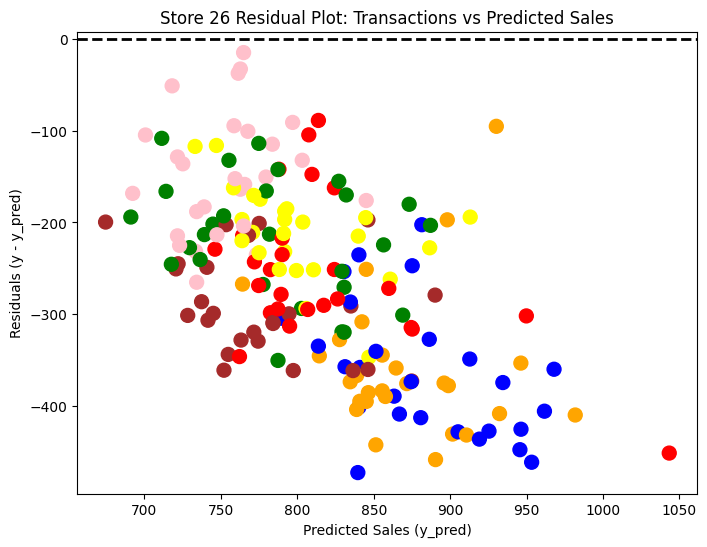

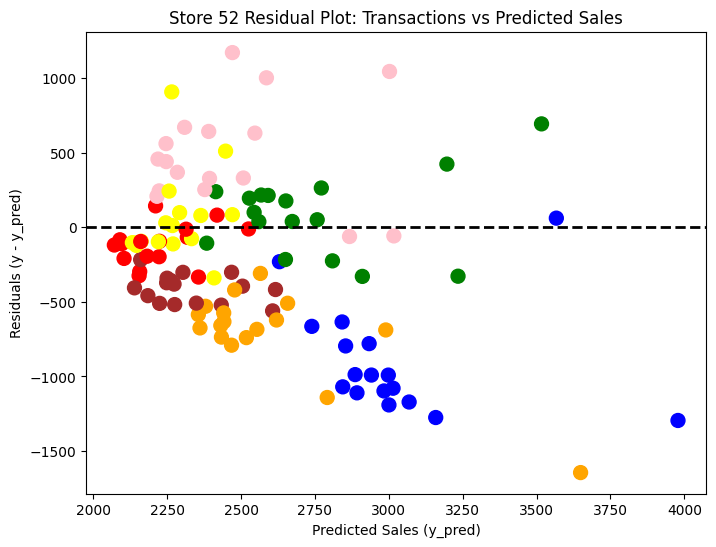

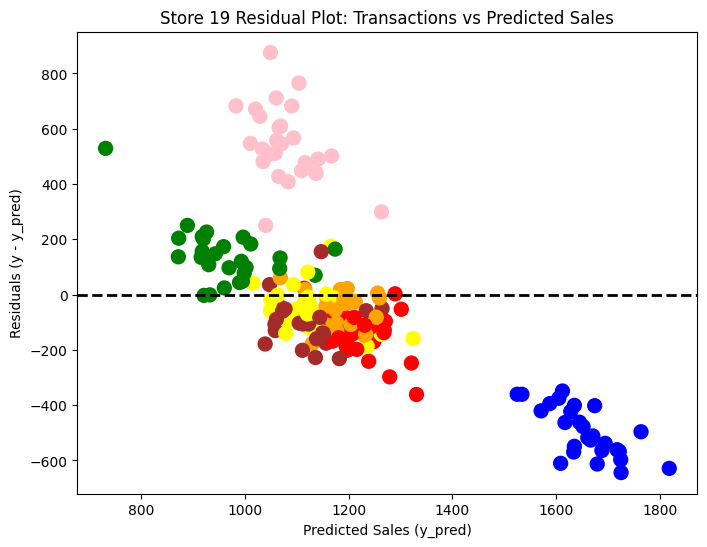

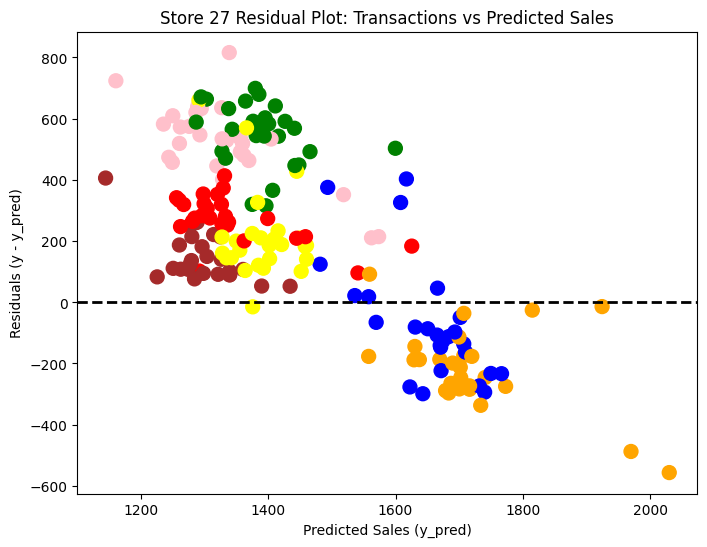

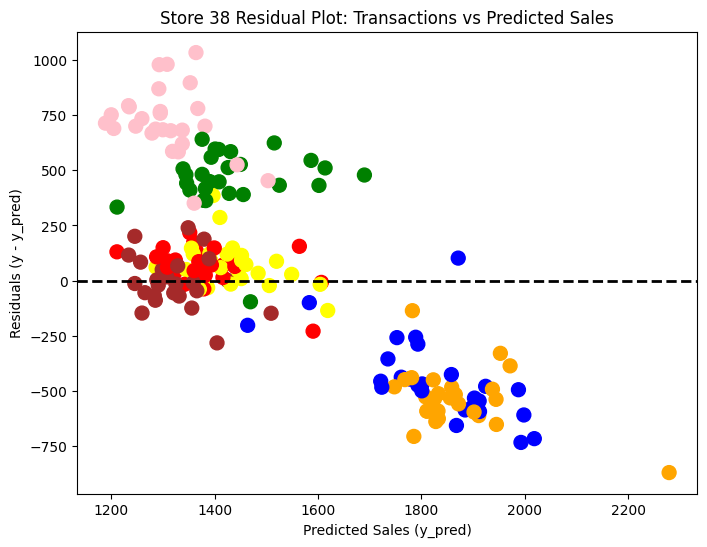

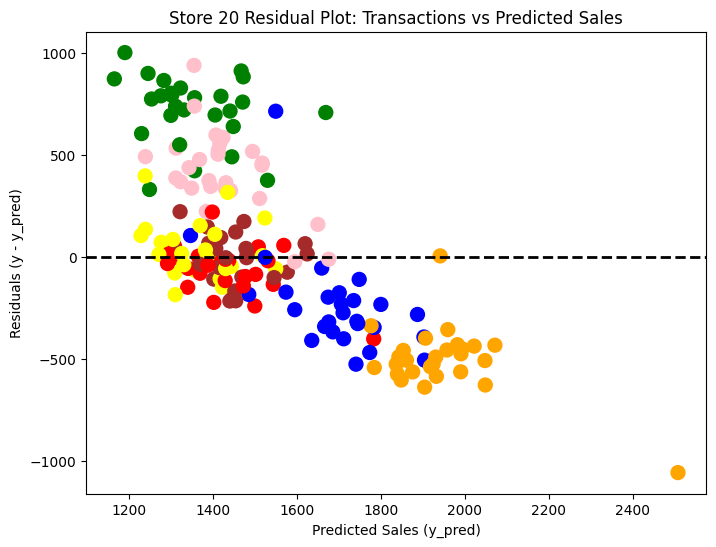

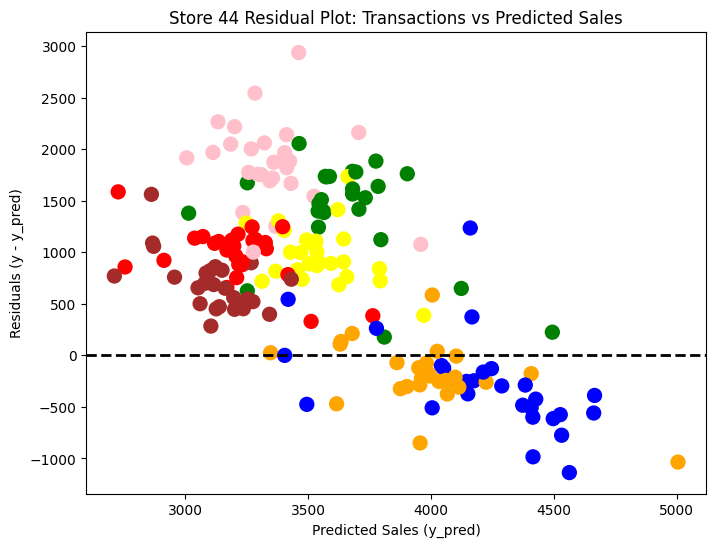

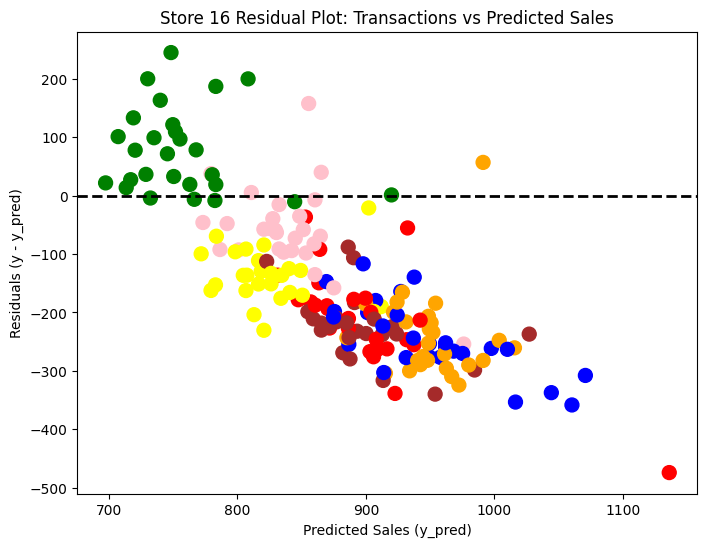

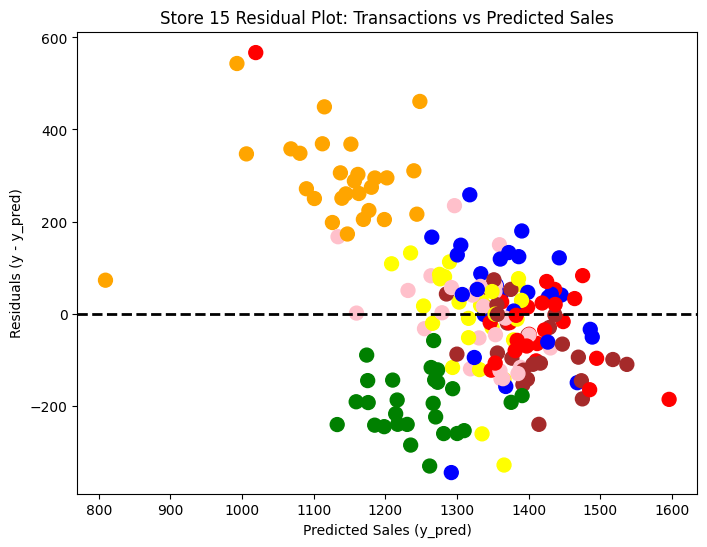

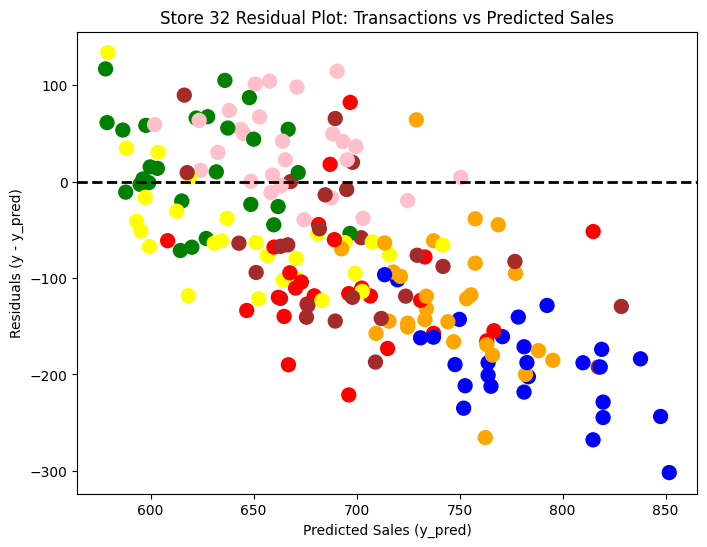

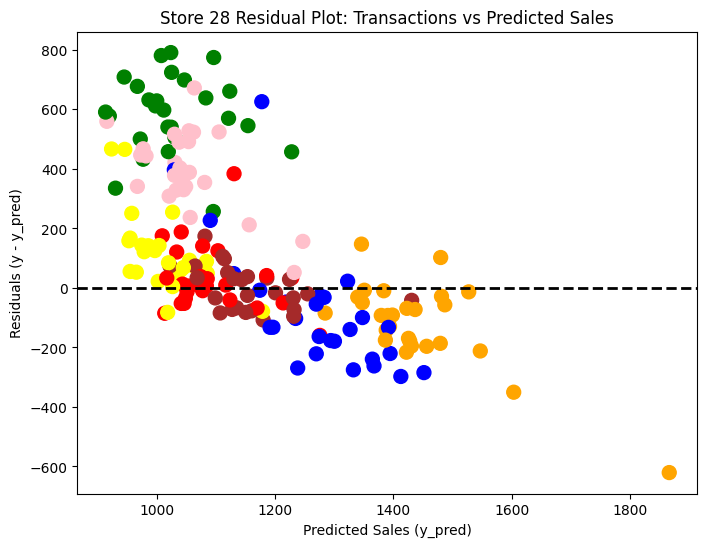

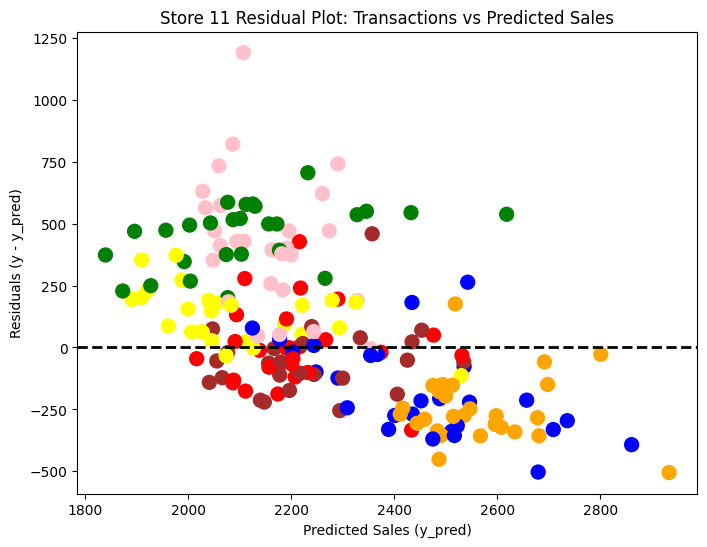

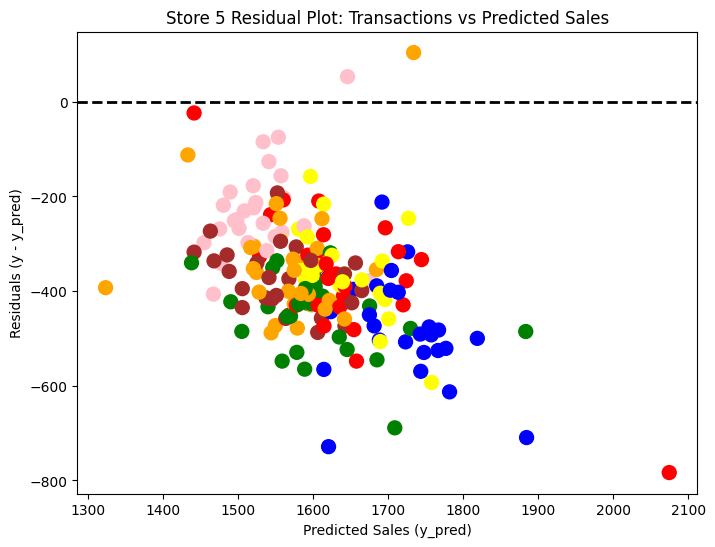

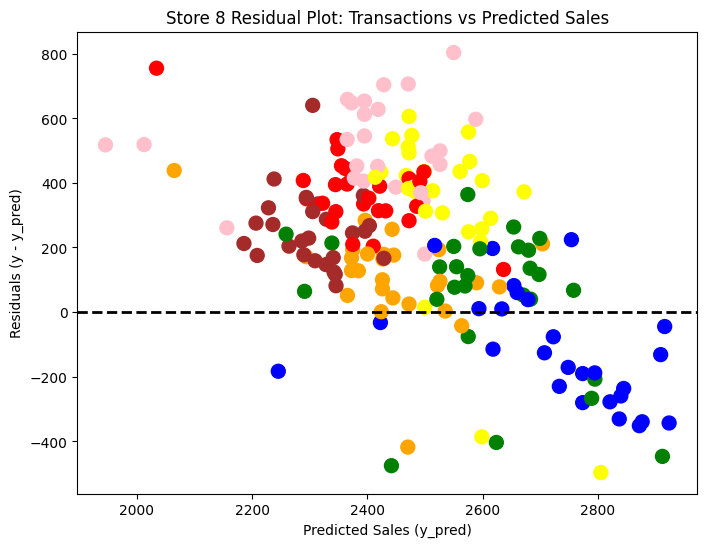

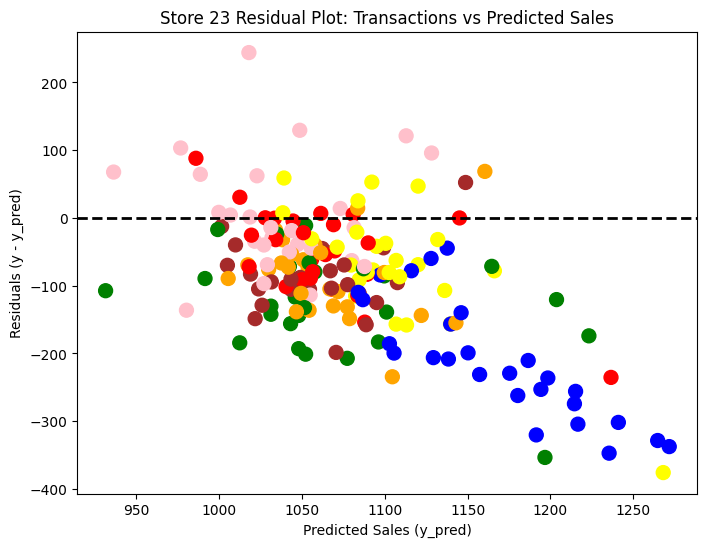

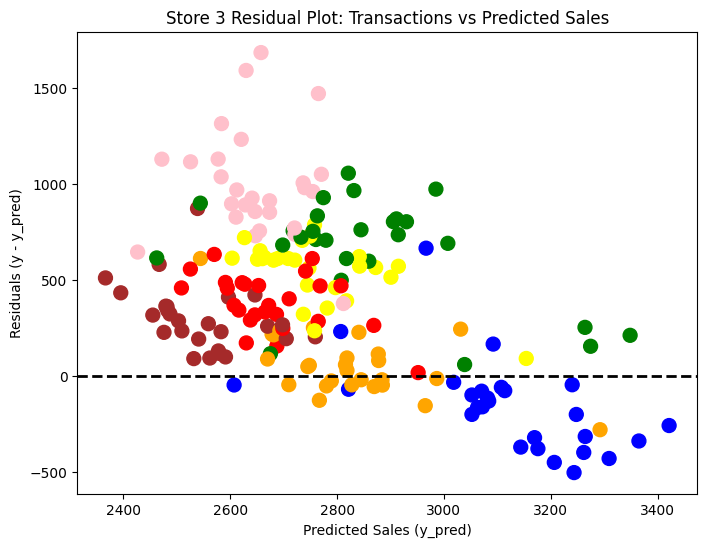

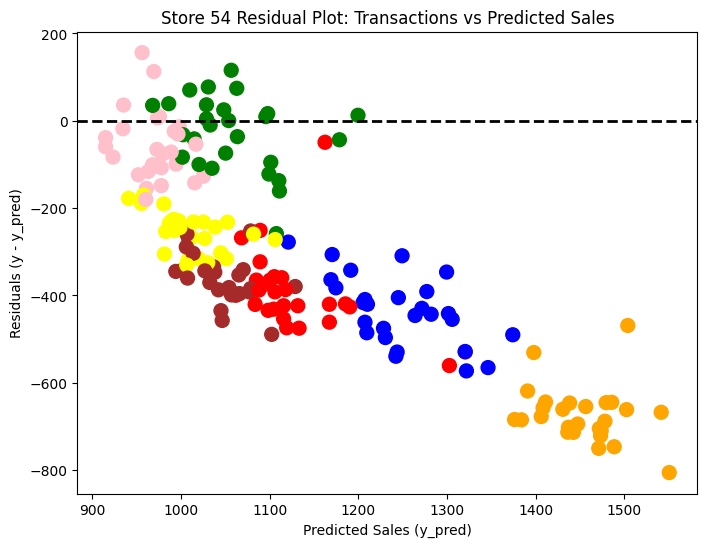

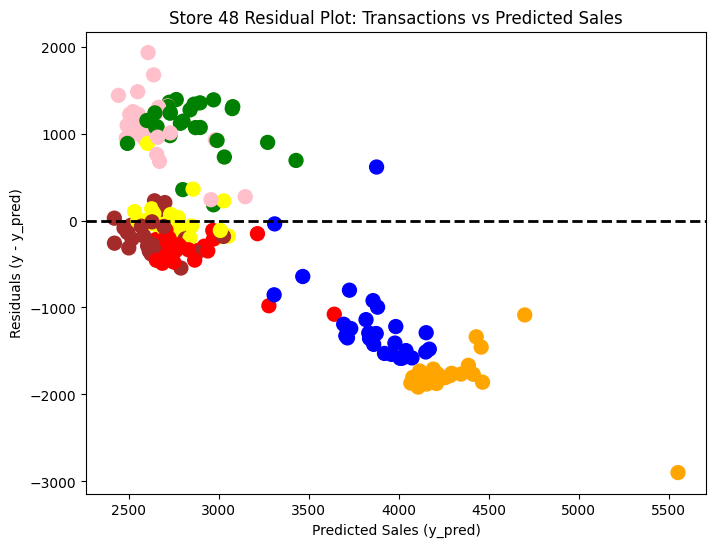

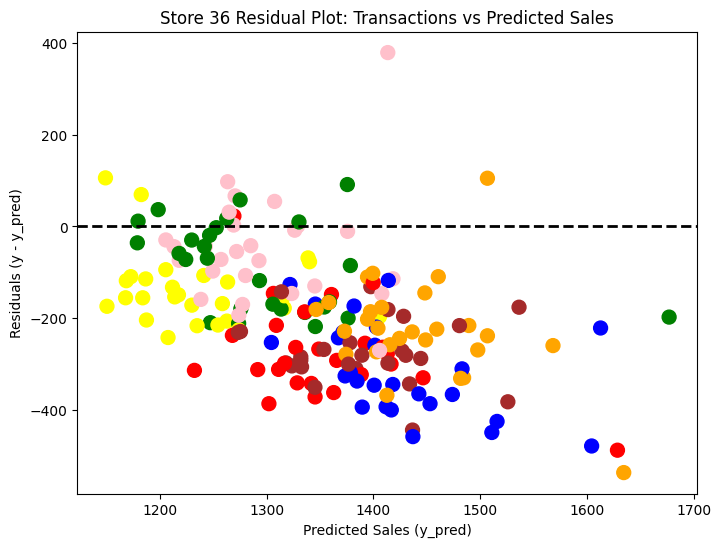

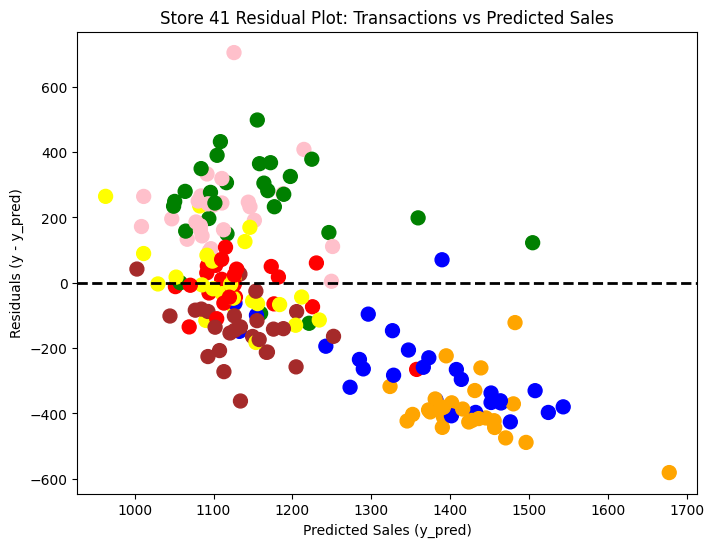

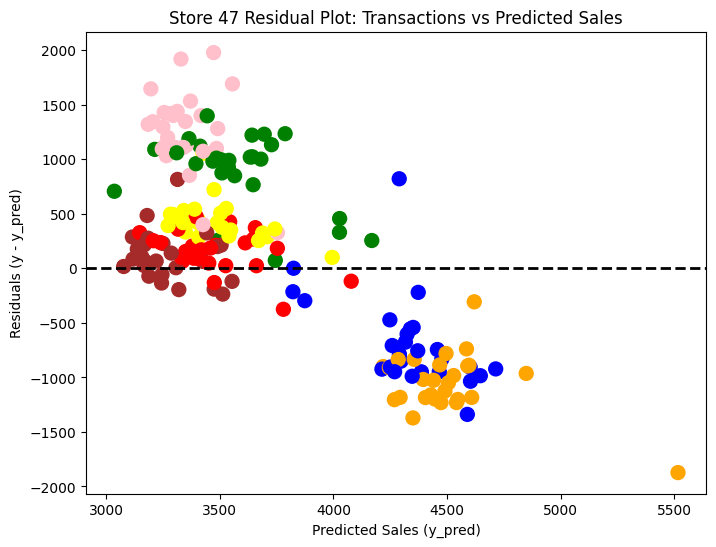

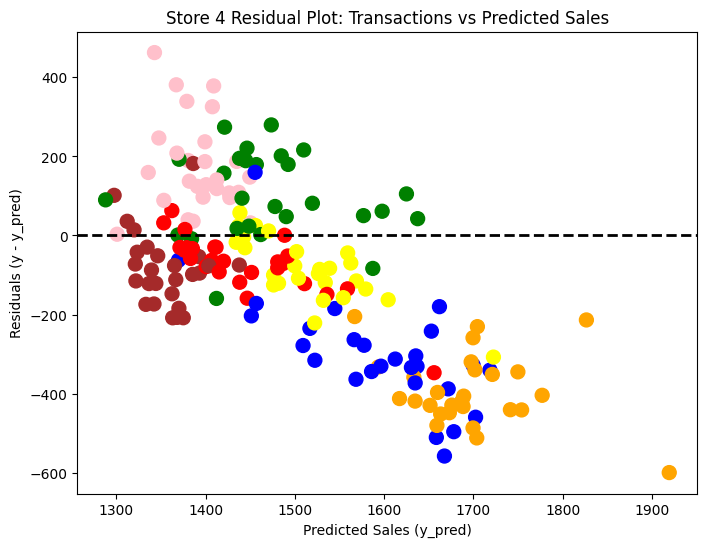

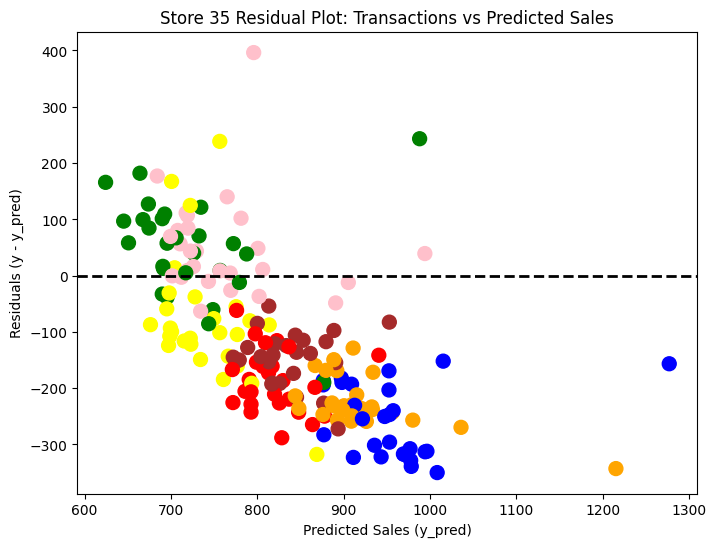

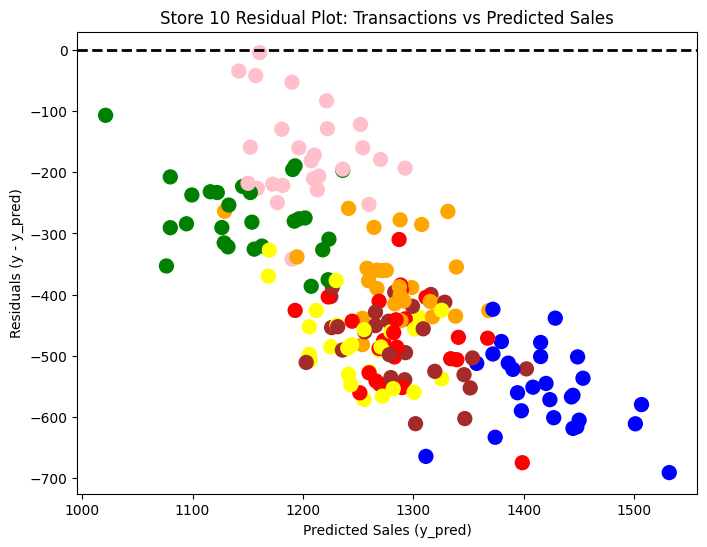

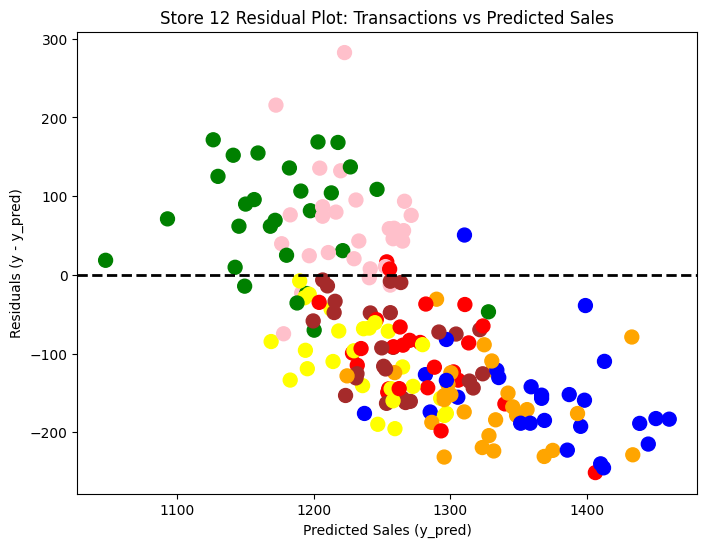

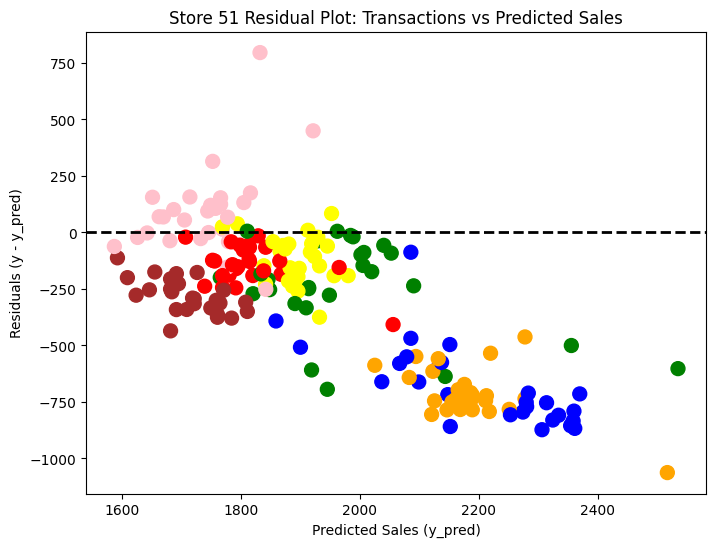

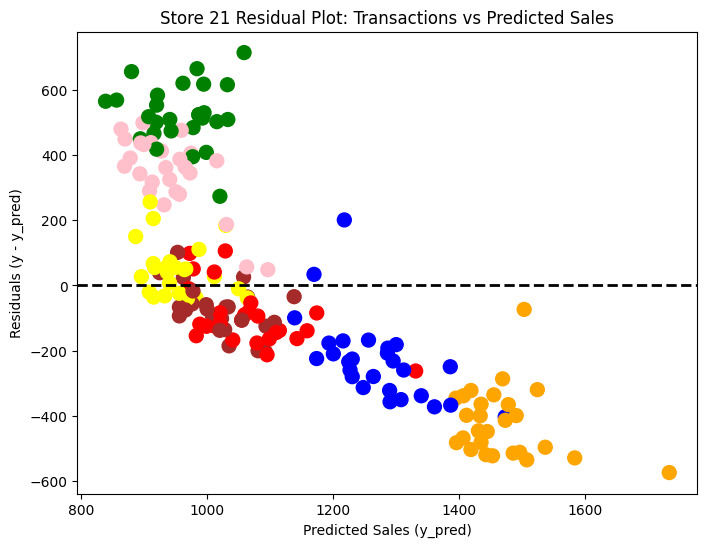

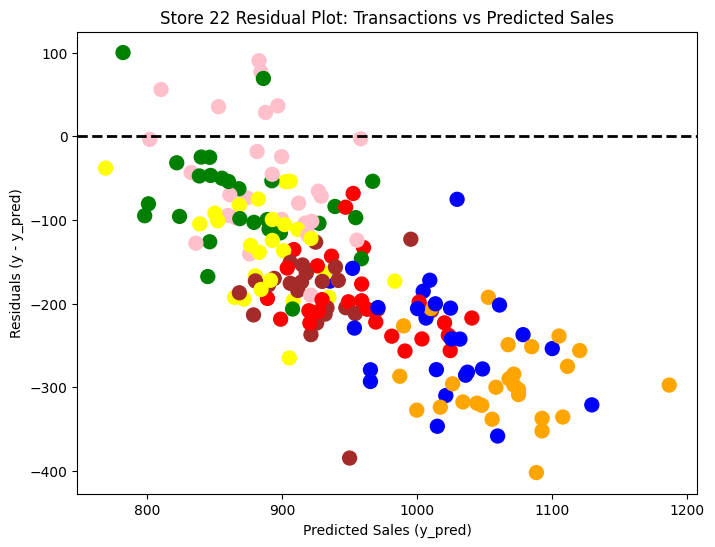

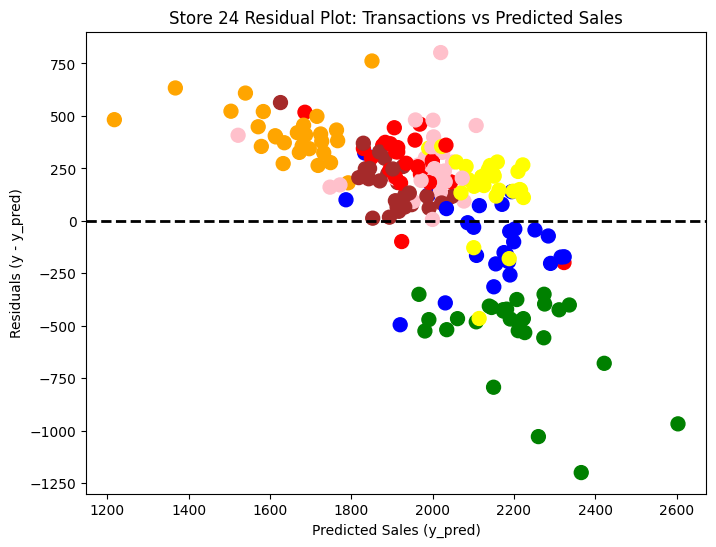

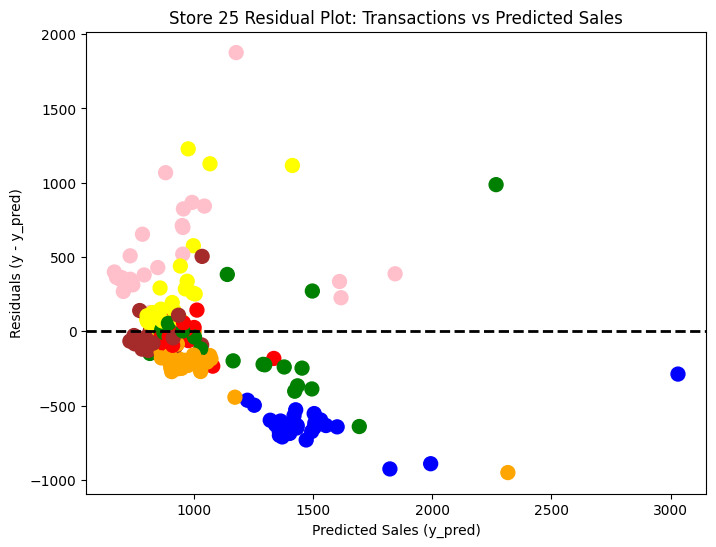

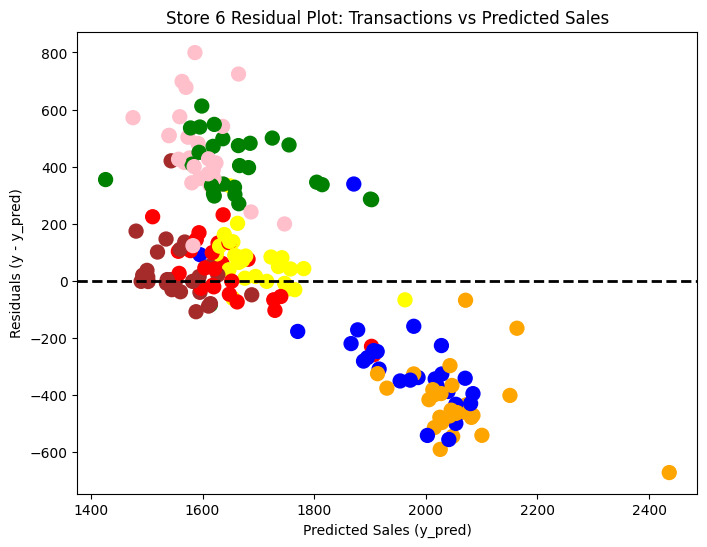

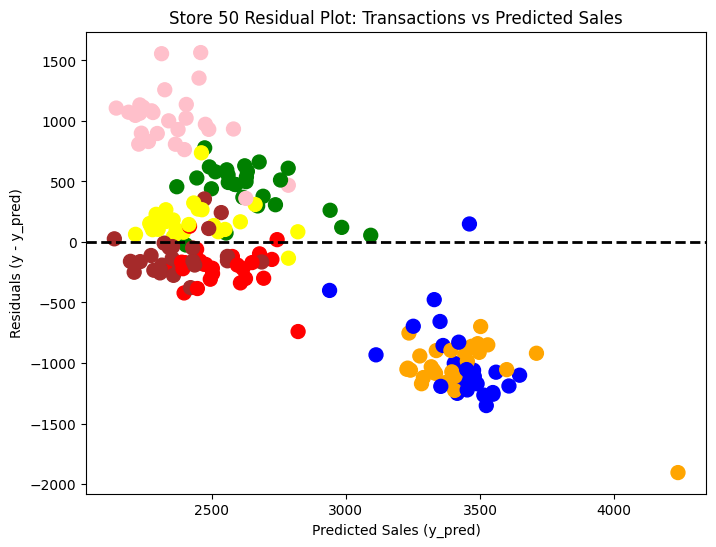

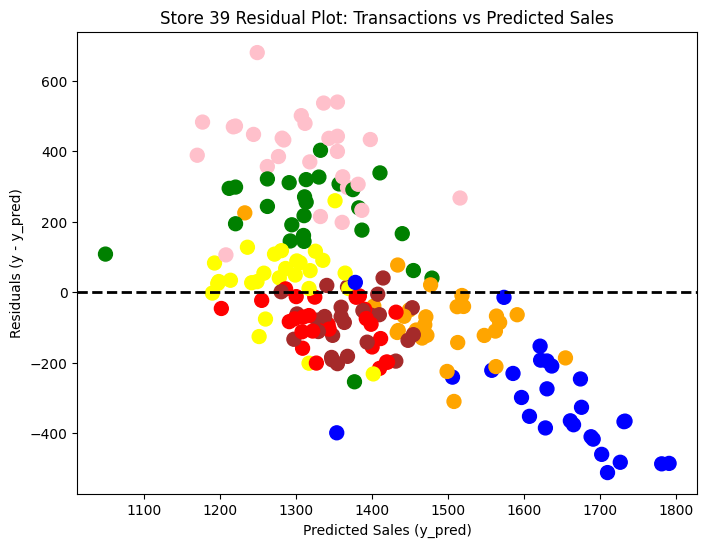

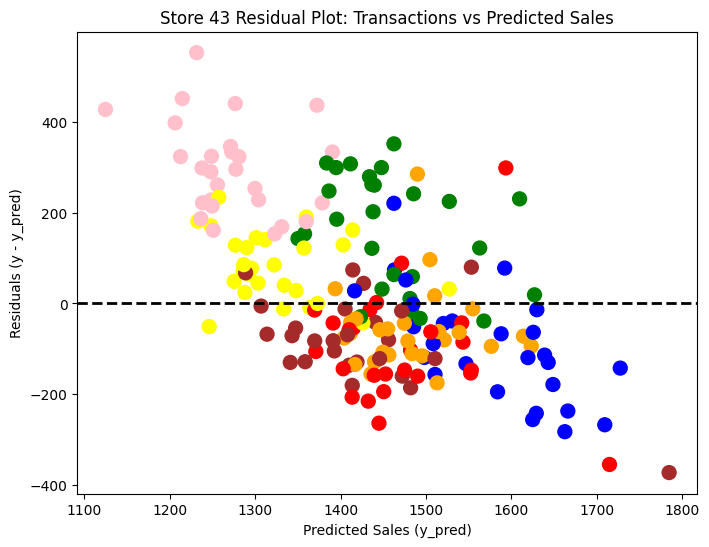

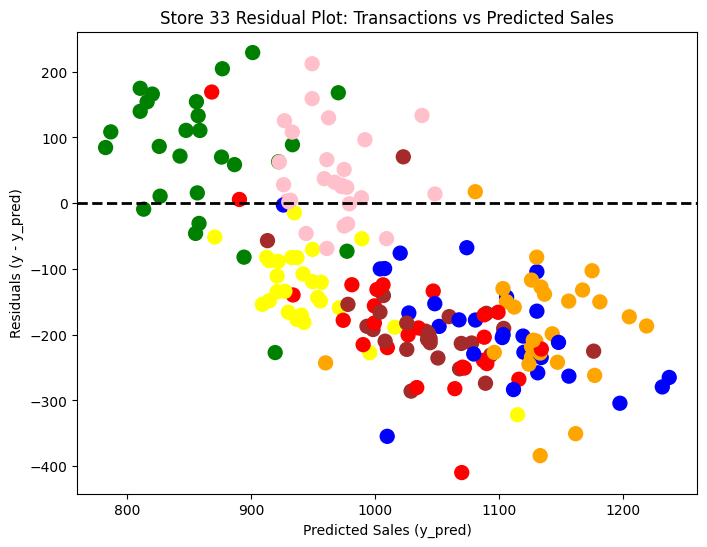

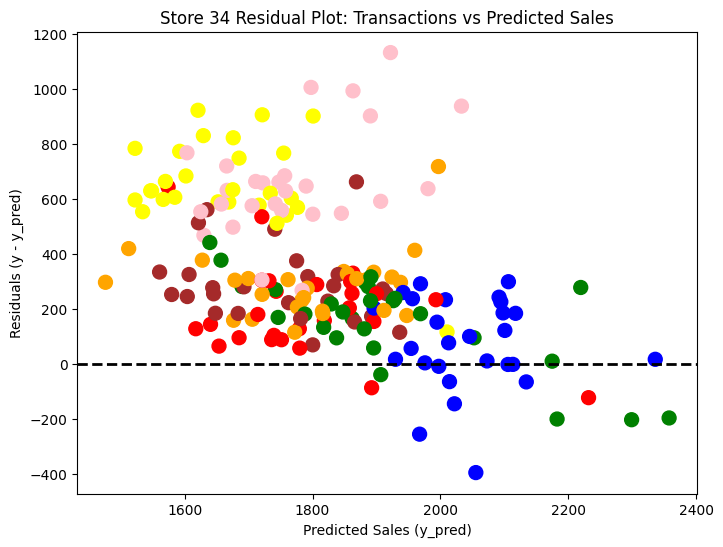

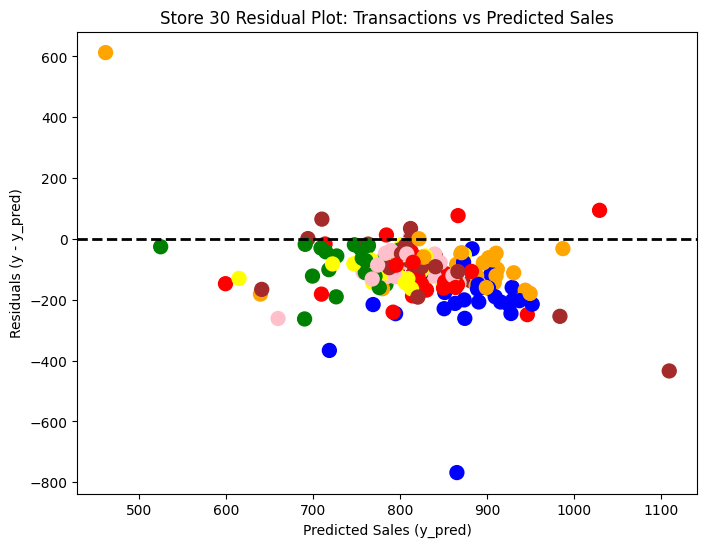

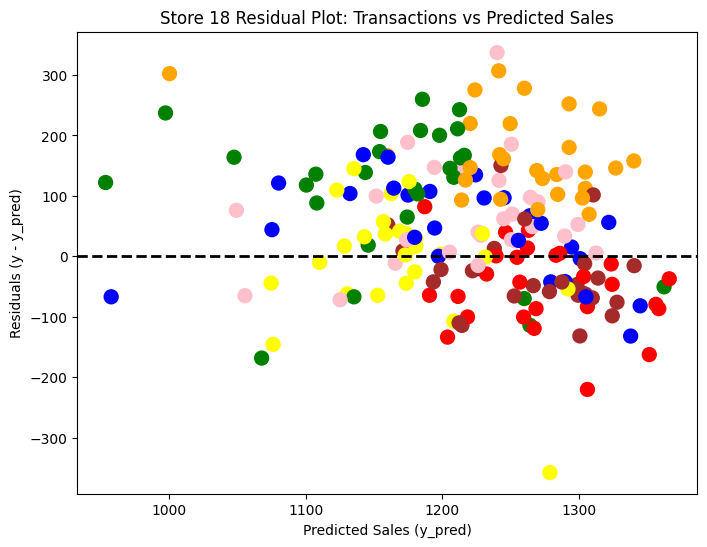

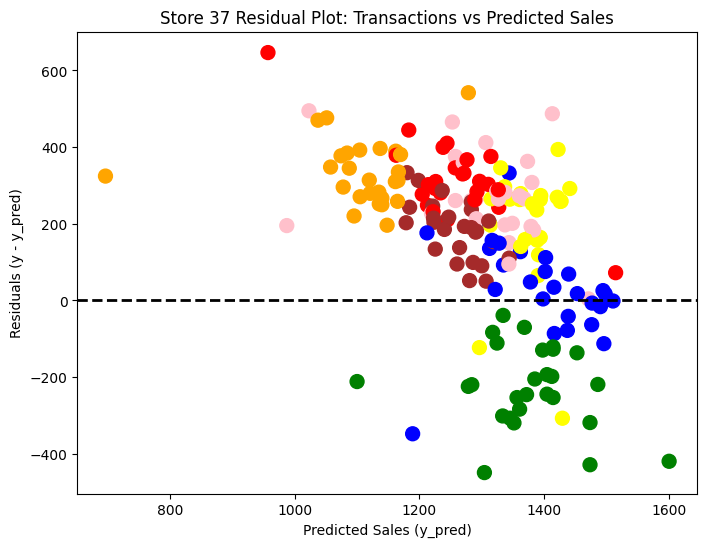

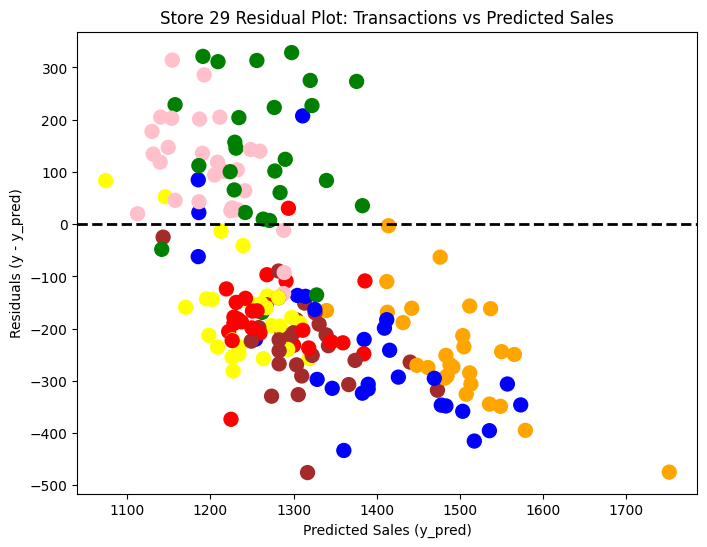

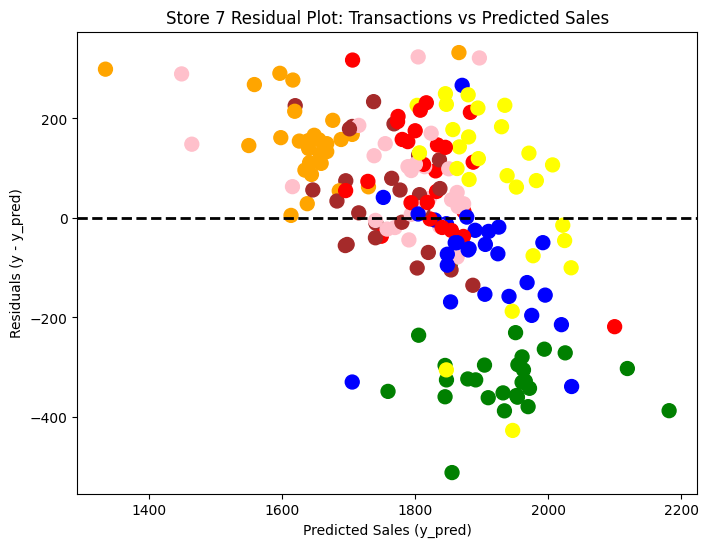

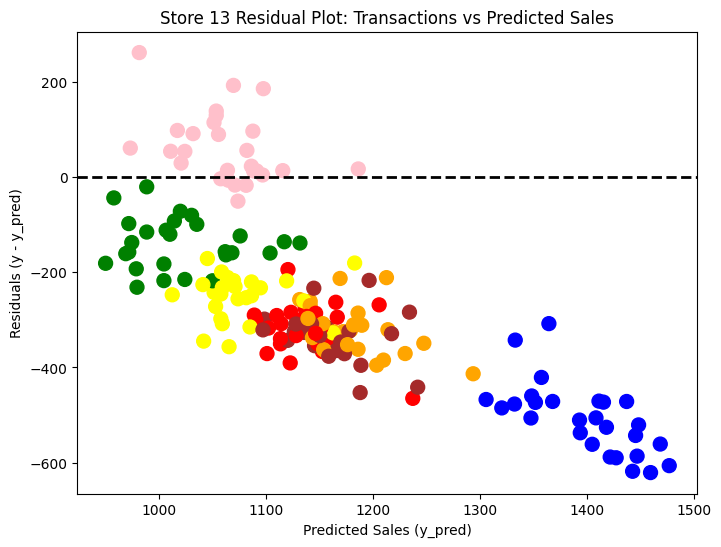

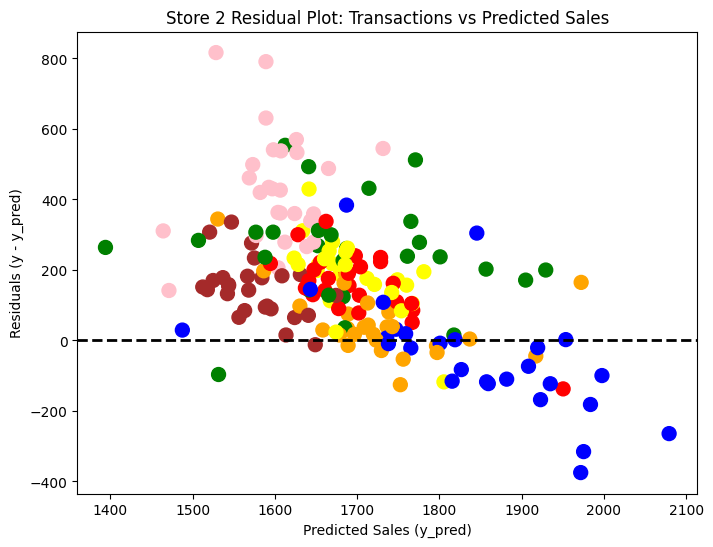

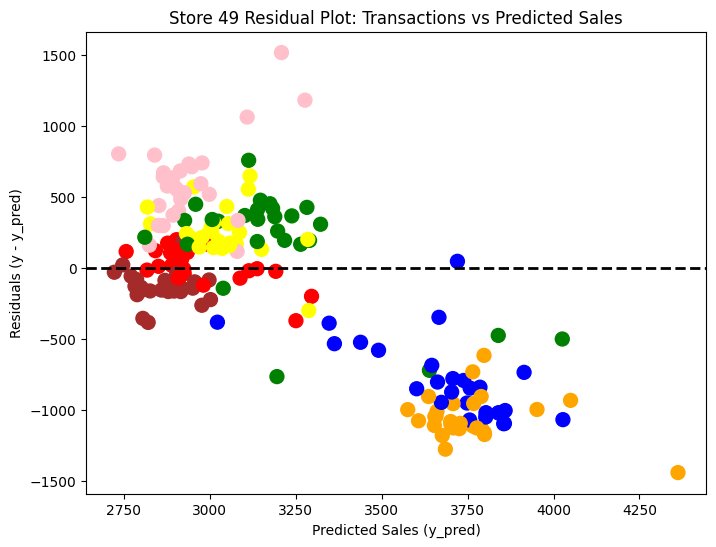

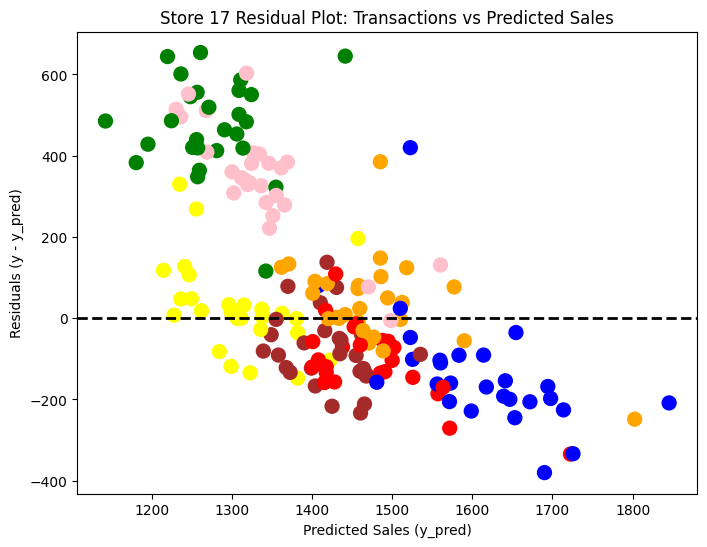

In [411]:
nbr = list(set(resid["store_nbr"]))
# Iterate over each store number and plot residuals
for i in nbr:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["store_nbr"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'Store {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

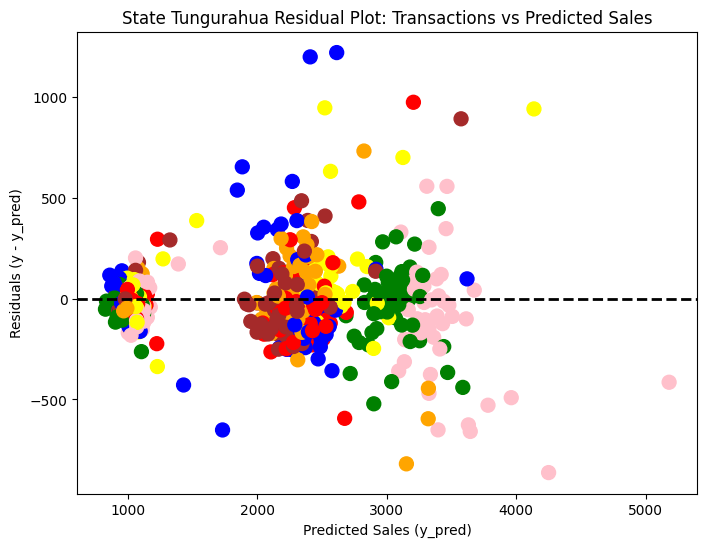

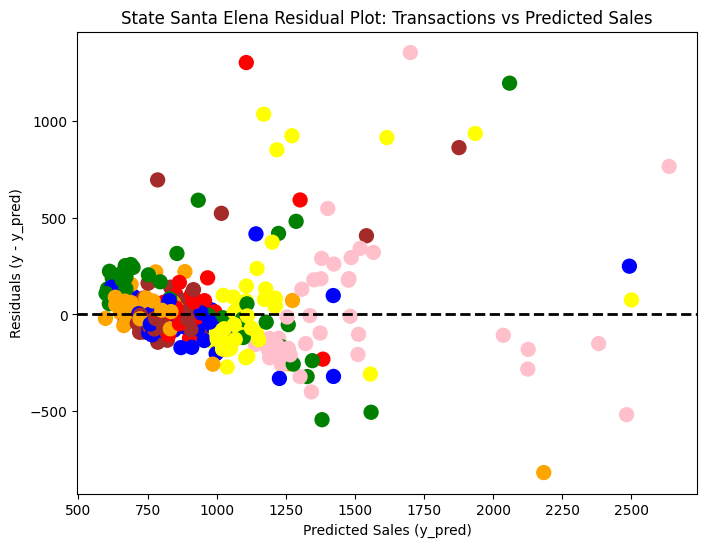

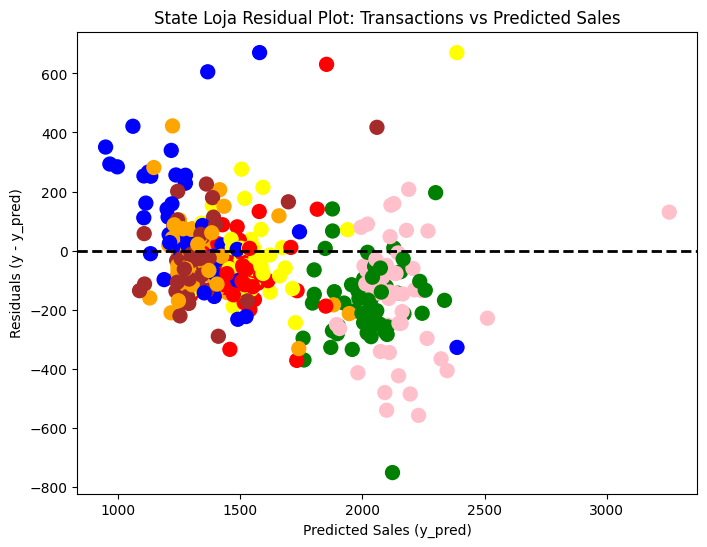

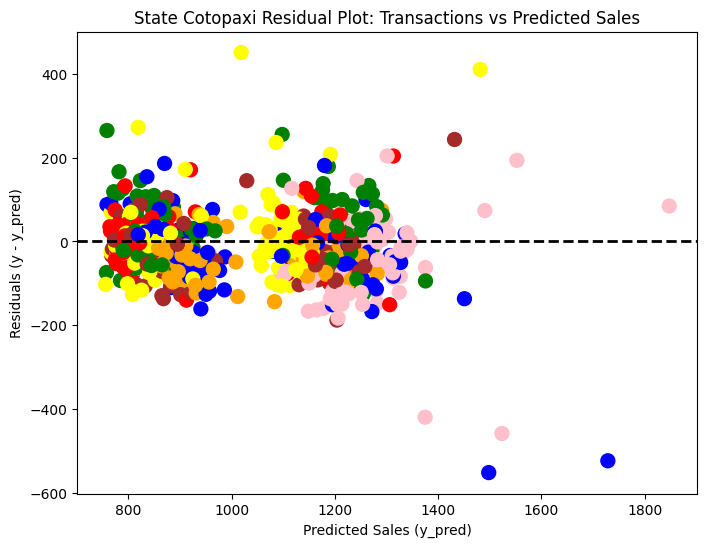

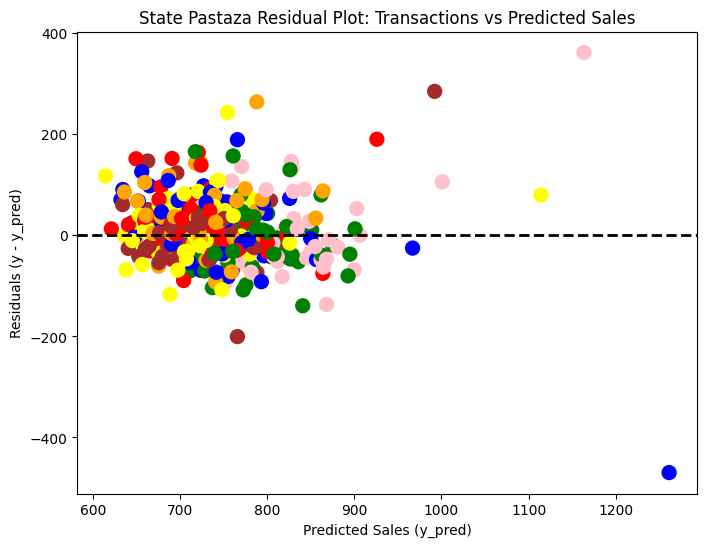

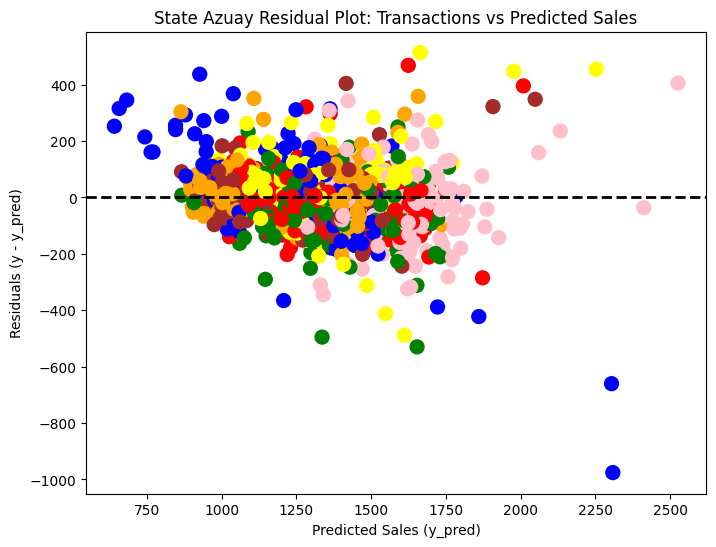

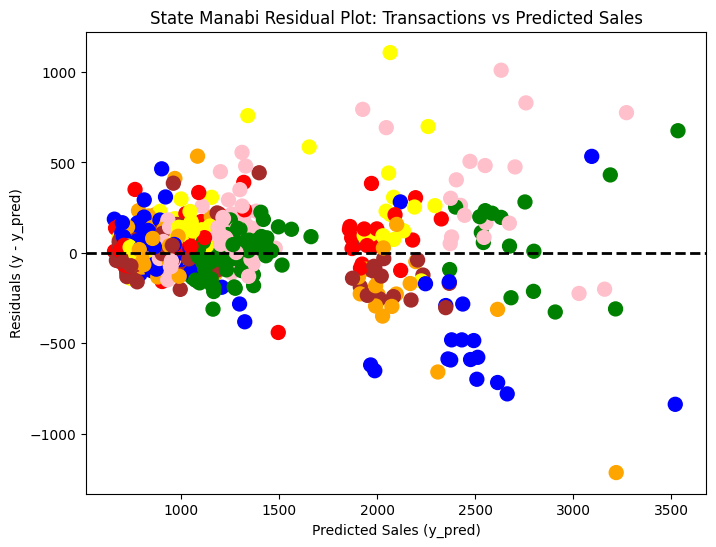

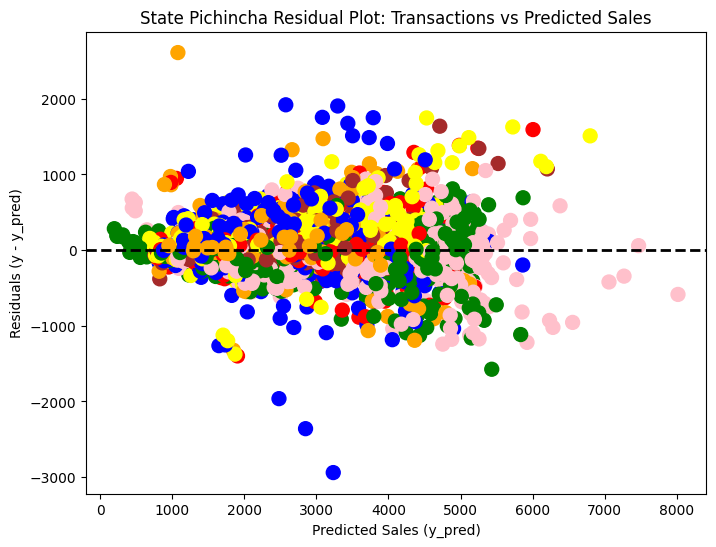

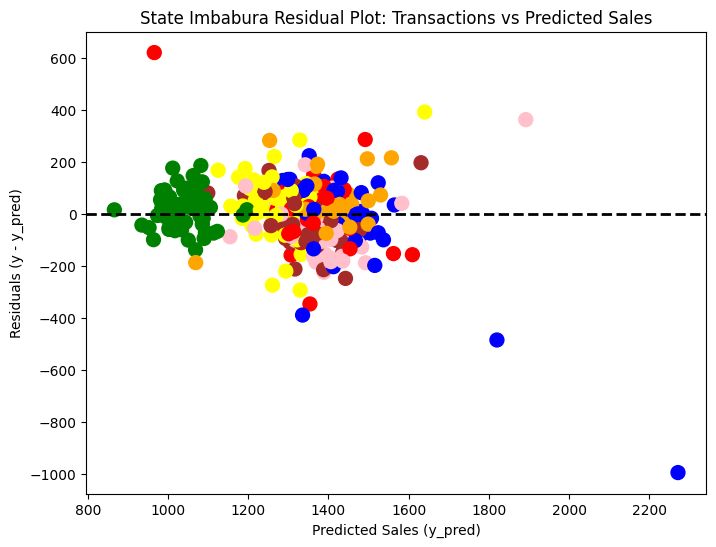

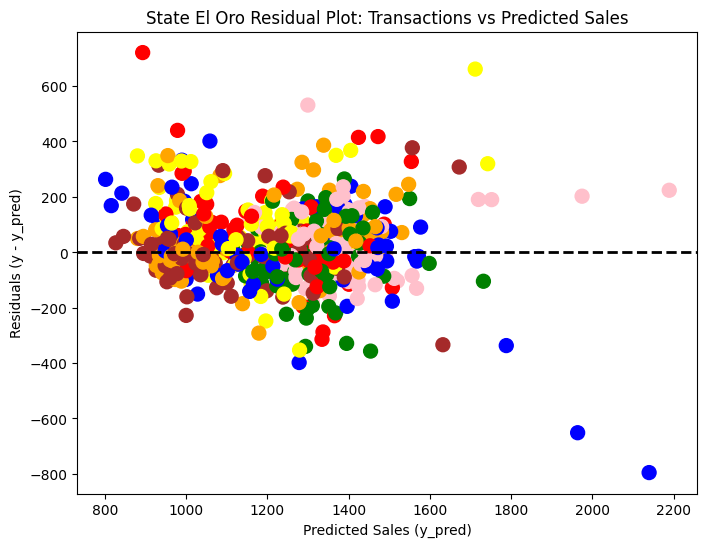

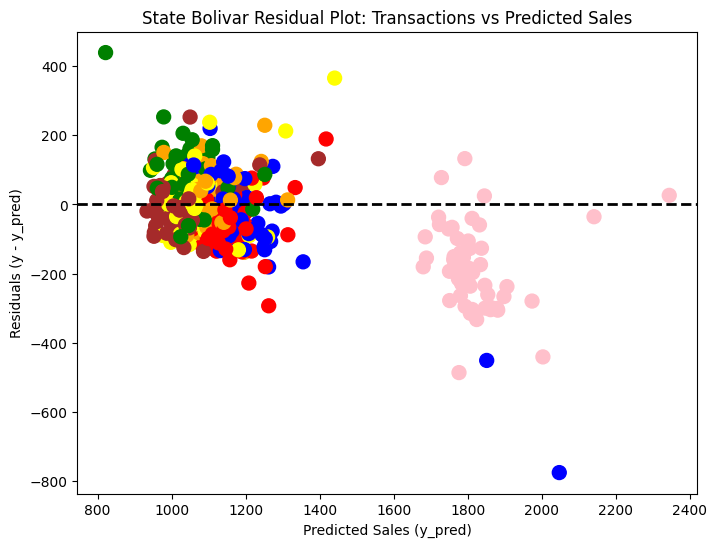

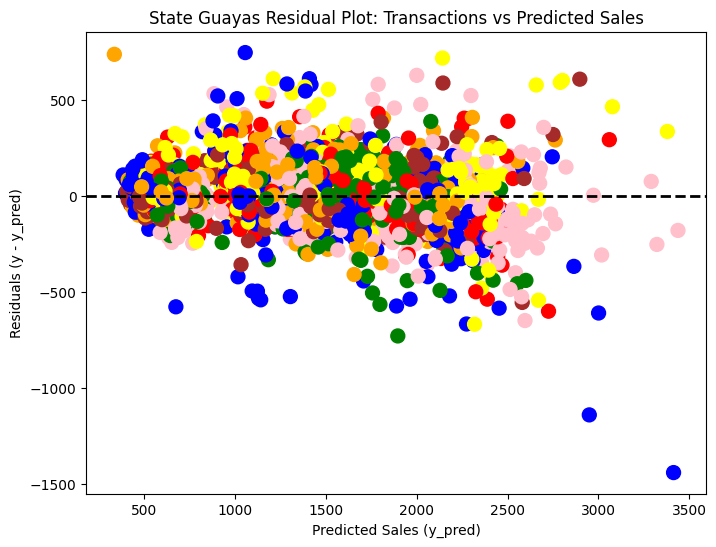

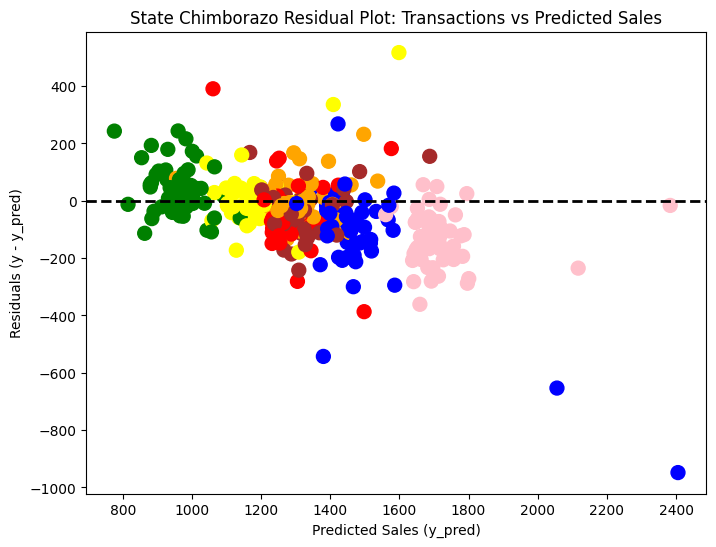

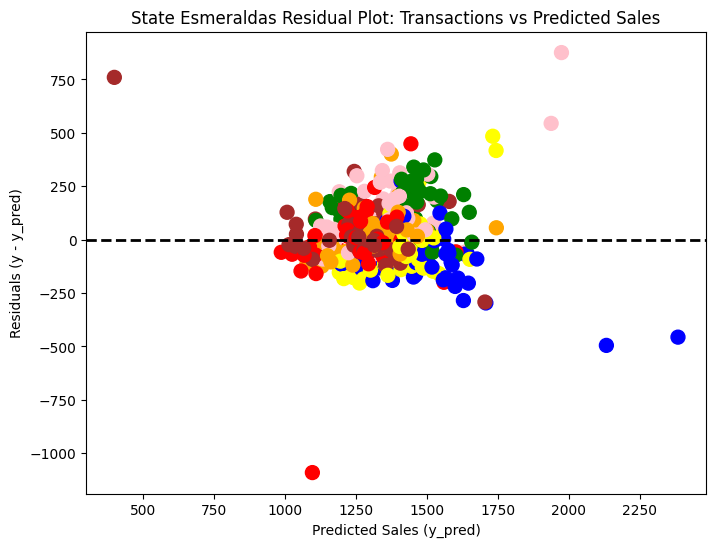

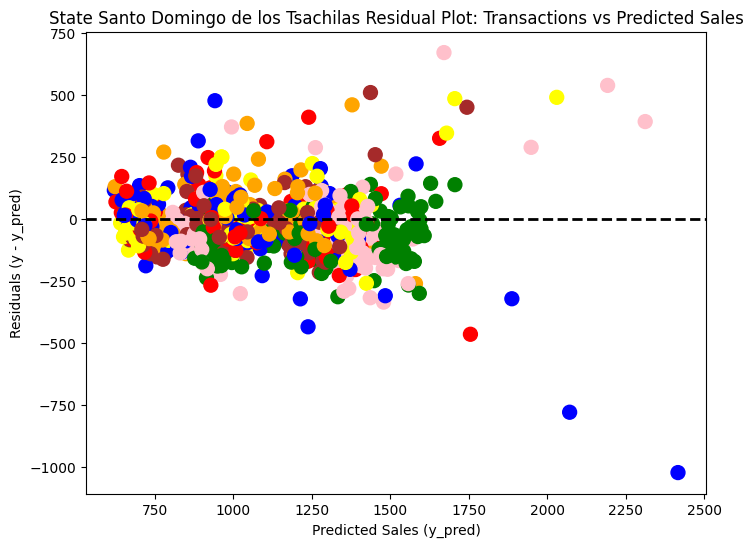

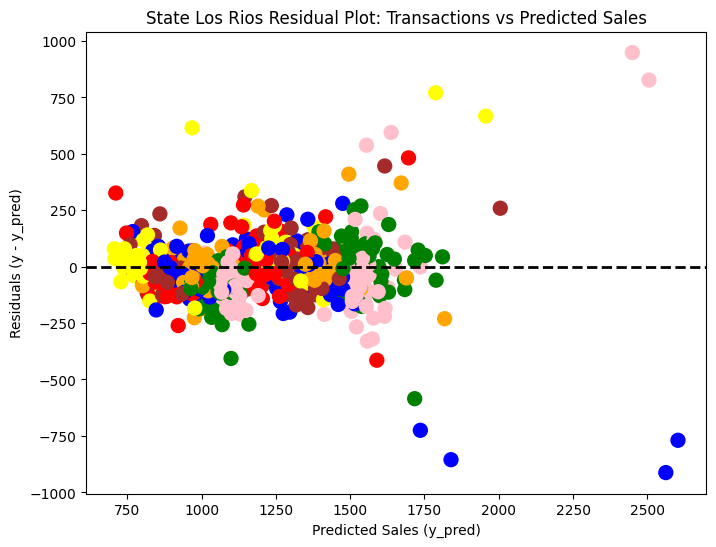

In [337]:
state = list(set(resid["state"]))
# Iterate over each store number and plot residuals
for i in state:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["state"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'State {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

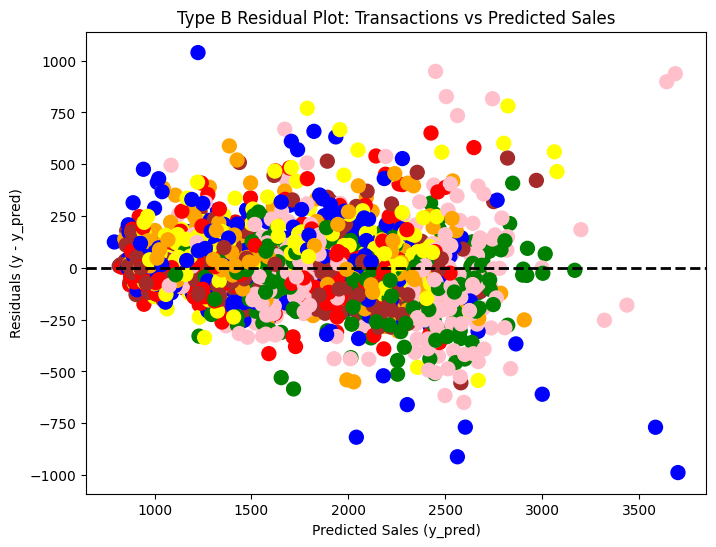

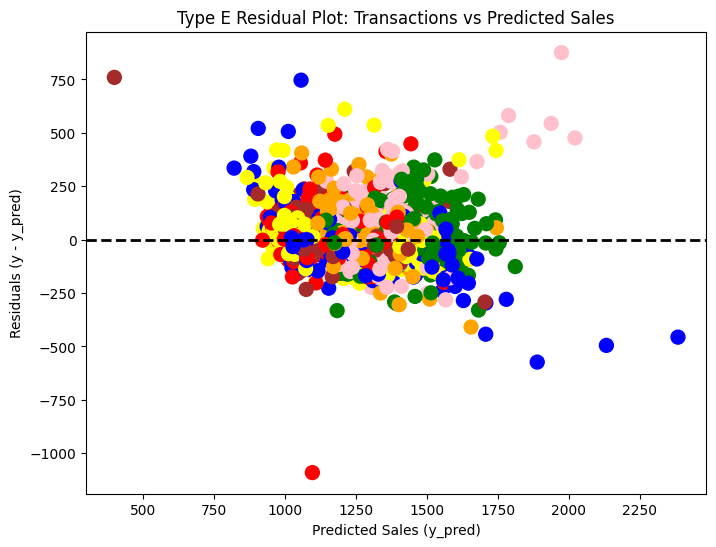

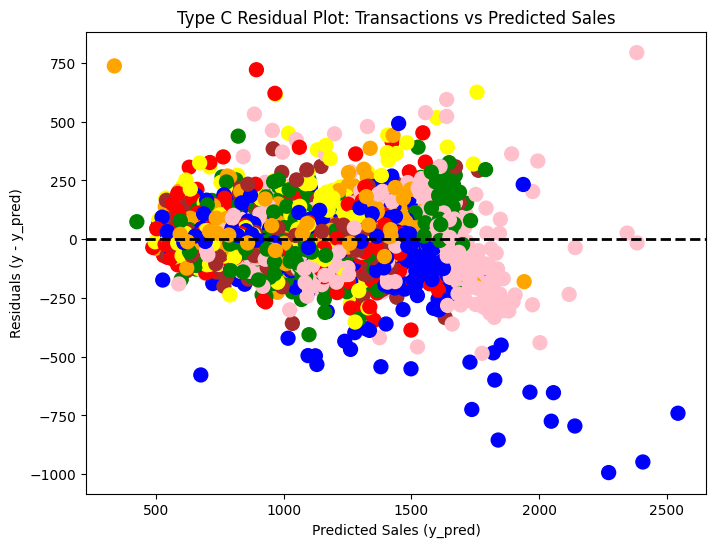

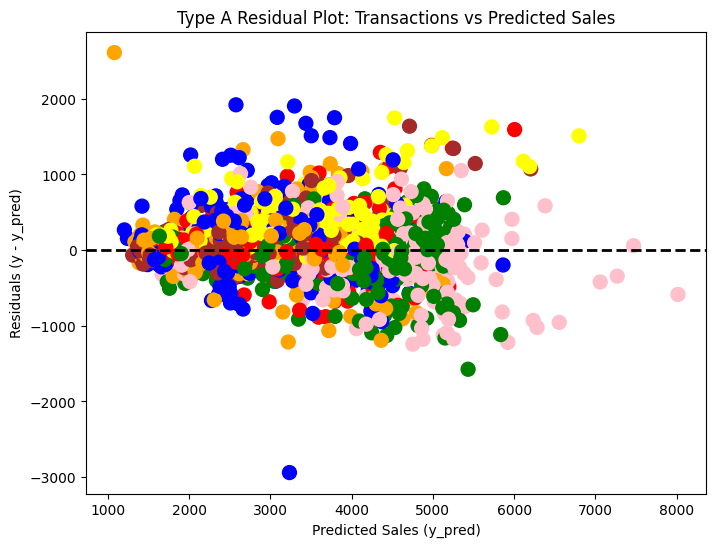

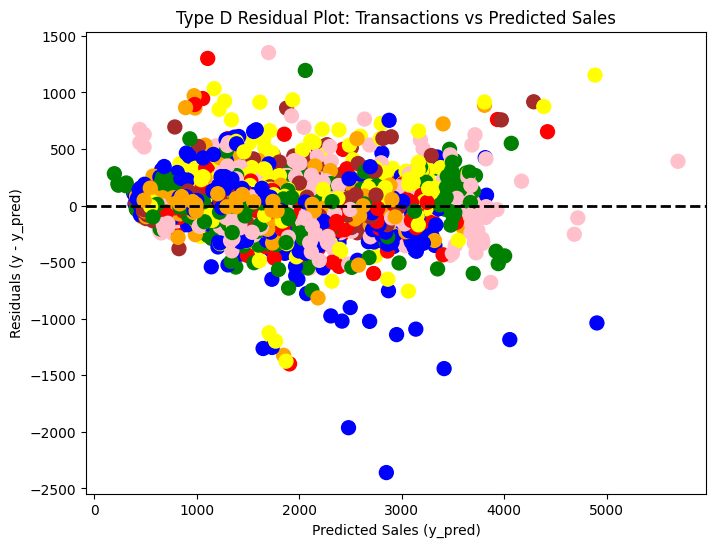

In [338]:
_type = list(set(resid["type"]))
# Iterate over each store number and plot residuals
for i in _type:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["type"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'Type {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

In [331]:
resid.to_csv('resid.csv')